**Chapter 17 – Autoencoders and GANs**

In [1]:
# Python ≥3.5 is required
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4897
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2092
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0971
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2233
Epoch 5/20
2/2 [==============================] - 0s 1000us/step - loss: 0.2137
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 9/20
2/2 [==============================] - 0s 999us/step - loss: 0.0063
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 12/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - los

In [8]:
codings = autoencoder.predict(X_train)
codings

2/2 [==============================] - 0s 2ms/step


array([[-1.0177934 , -0.75209427, -0.36686733],
       [-0.0479149 ,  0.3000401 ,  0.09960037],
       [-0.9599073 , -0.67686766, -0.33468372],
       [-0.92060417,  0.01139341, -0.09022082],
       [-0.7290678 ,  0.03383101, -0.06285321],
       [ 1.1338446 ,  0.1334031 ,  0.16187267],
       [-0.9928847 , -0.77445793, -0.37214082],
       [ 0.6739168 , -0.49290797, -0.10383296],
       [ 1.0501943 ,  0.36589676,  0.23456943],
       [ 0.5339637 ,  0.4243769 ,  0.20236667],
       [-1.0033078 , -0.21823603, -0.17887804],
       [ 1.1019773 , -0.01200248,  0.10782368],
       [-0.99493265, -0.46853733, -0.2654711 ],
       [-0.9303006 , -0.65863526, -0.32529524],
       [ 1.084296  , -0.0925552 ,  0.07787846],
       [-0.3646332 ,  0.20645243,  0.03461199],
       [ 0.6809651 , -0.5162948 , -0.1112849 ],
       [ 0.66575855,  0.44576132,  0.22327523],
       [ 0.86432916, -0.41995102, -0.05893019],
       [-1.091603  , -0.746083  , -0.3722927 ],
       [ 0.5398655 ,  0.48451918,  0.223

Saving figure linear_autoencoder_pca_plot


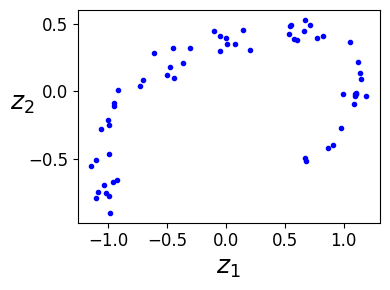

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=20,validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3368 - rounded_accuracy: 0.8883 - val_loss: 0.3114 - val_rounded_accuracy: 0.9132
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3048 - rounded_accuracy: 0.9158 - val_loss: 0.3025 - val_rounded_accuracy: 0.9200
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2990 - rounded_accuracy: 0.9211 - val_loss: 0.2995 - val_rounded_accuracy: 0.9189
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2953 - rounded_accuracy: 0.9243 - val_loss: 0.2951 - val_rounded_accuracy: 0.9269
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2927 - rounded_accuracy: 0.9267 - val_loss: 0.2925 - val_rounded_accuracy: 0.9283
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2909 - rounded_accuracy: 0.9283 - val_loss: 0.2914 - val_rounded_accuracy: 0.9304
Epoch 7/20
1719/1719 [==================

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [13]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 48ms/step
Saving figure reconstruction_plot


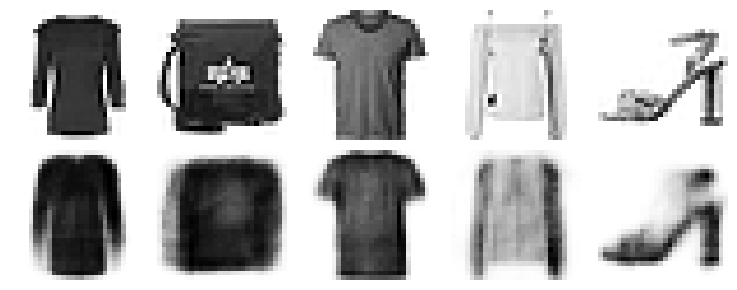

In [14]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [15]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 598us/step


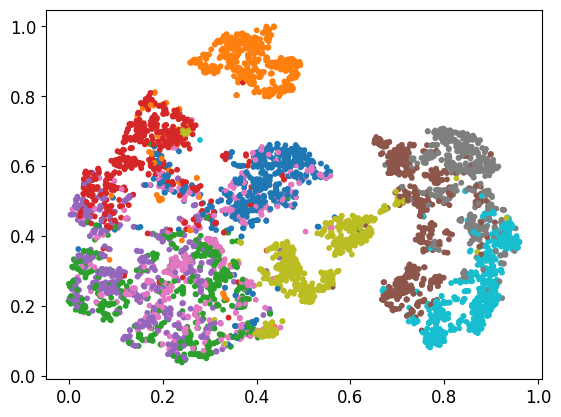

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis()
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


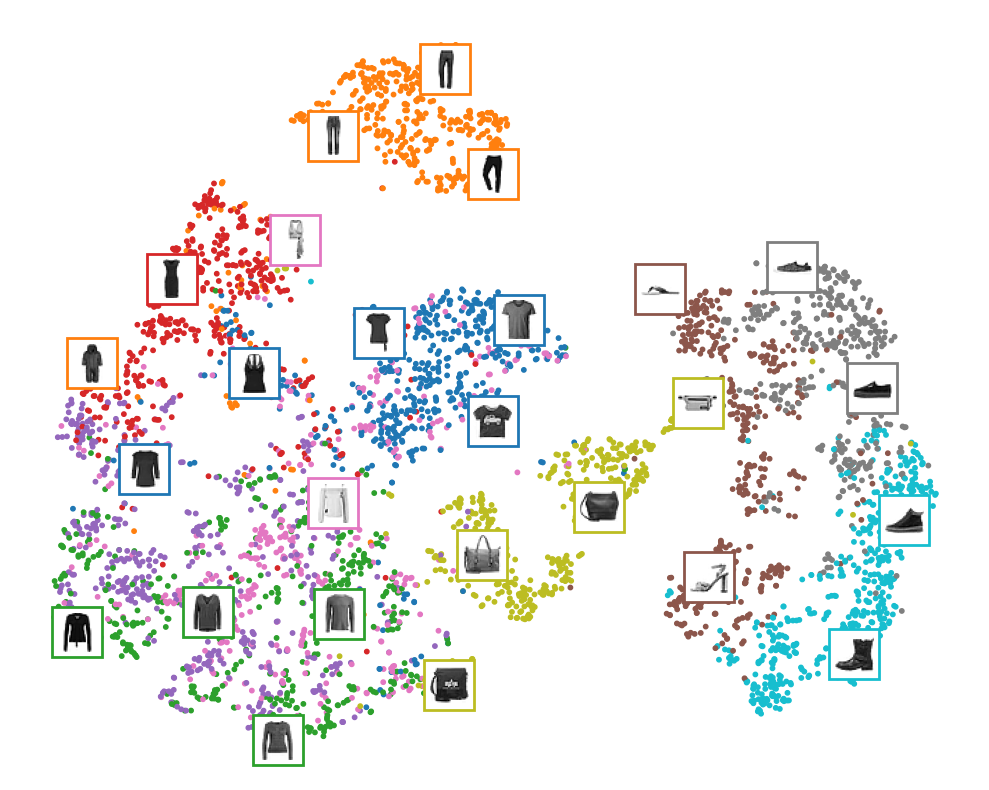

In [17]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [18]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3266 - rounded_accuracy: 0.8961 - val_loss: 0.3090 - val_rounded_accuracy: 0.9058
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2971 - rounded_accuracy: 0.9228 - val_loss: 0.2968 - val_rounded_accuracy: 0.9274
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2910 - rounded_accuracy: 0.9284 - val_loss: 0.2912 - val_rounded_accuracy: 0.9280
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2880 - rounded_accuracy: 0.9311 - val_loss: 0.2874 - val_rounded_accuracy: 0.9338
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2860 - rounded_accuracy: 0.9328 - val_loss: 0.2866 - val_rounded_accuracy: 0.9321
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2847 - rounded_accuracy: 0.9342 - val_loss: 0.2850 - val_rounded_accuracy: 0.9359
Epoch 7/10
1719/1719 [==================

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [20]:
tf.random.set_seed(42)
np.random.seed(42)


conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3022 - rounded_accuracy: 0.9180 - val_loss: 0.2841 - val_rounded_accuracy: 0.9379
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2764 - rounded_accuracy: 0.9404 - val_loss: 0.2734 - val_rounded_accuracy: 0.9450
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2714 - rounded_accuracy: 0.9453 - val_loss: 0.2750 - val_rounded_accuracy: 0.9385
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2688 - rounded_accuracy: 0.9481 - val_loss: 0.2693 - val_rounded_accuracy: 0.9481
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2670 - rounded_accuracy: 0.9500 - val_loss: 0.2667 - val_rounded_accuracy: 0.9523


In [21]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

1/1 [==============================] - 0s 91ms/step


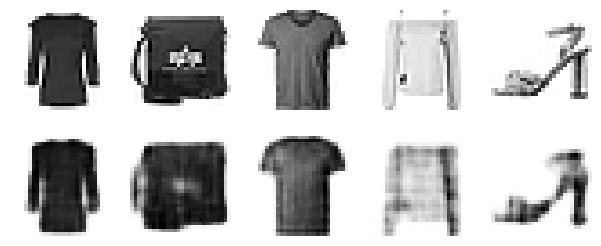

In [22]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [23]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [24]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 29s 15ms/step - loss: 0.5258 - rounded_accuracy: 0.7305 - val_loss: 0.4606 - val_rounded_accuracy: 0.8032
Epoch 2/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.4182 - rounded_accuracy: 0.8310 - val_loss: 0.3852 - val_rounded_accuracy: 0.8478
Epoch 3/10
1719/1719 [==============================] - 25s 15ms/step - loss: 0.3689 - rounded_accuracy: 0.8684 - val_loss: 0.3602 - val_rounded_accuracy: 0.8755
Epoch 4/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3540 - rounded_accuracy: 0.8787 - val_loss: 0.3494 - val_rounded_accuracy: 0.8830
Epoch 5/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3438 - rounded_accuracy: 0.8852 - val_loss: 0.3389 - val_rounded_accuracy: 0.8889
Epoch 6/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3362 - rounded_accuracy: 0.8897 - val_loss: 0.3354 - val_rounded_accuracy: 0.8940
Epoch 7/10
1719/1719 [======

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3489 - rounded_accuracy: 0.8784 - val_loss: 0.3175 - val_rounded_accuracy: 0.9082
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3117 - rounded_accuracy: 0.9100 - val_loss: 0.3076 - val_rounded_accuracy: 0.9166
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3053 - rounded_accuracy: 0.9155 - val_loss: 0.3035 - val_rounded_accuracy: 0.9161
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3015 - rounded_accuracy: 0.9190 - val_loss: 0.2991 - val_rounded_accuracy: 0.9229
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2988 - rounded_accuracy: 0.9213 - val_loss: 0.2966 - val_rounded_accuracy: 0.9247
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2969 - rounded_accuracy: 0.9229 - val_loss: 0.2957 - val_rounded_accuracy: 0.9273
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 46ms/step


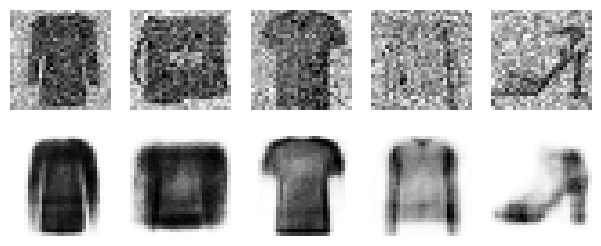

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3555 - rounded_accuracy: 0.8721 - val_loss: 0.3215 - val_rounded_accuracy: 0.9030
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3194 - rounded_accuracy: 0.9021 - val_loss: 0.3128 - val_rounded_accuracy: 0.9099
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3137 - rounded_accuracy: 0.9068 - val_loss: 0.3088 - val_rounded_accuracy: 0.9141
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3104 - rounded_accuracy: 0.9094 - val_loss: 0.3058 - val_rounded_accuracy: 0.9167
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3079 - rounded_accuracy: 0.9114 - val_loss: 0.3030 - val_rounded_accuracy: 0.9177
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3059 - rounded_accuracy: 0.9130 - val_loss: 0.3021 - val_rounded_accuracy: 0.9178
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 45ms/step
Saving figure dropout_denoising_plot


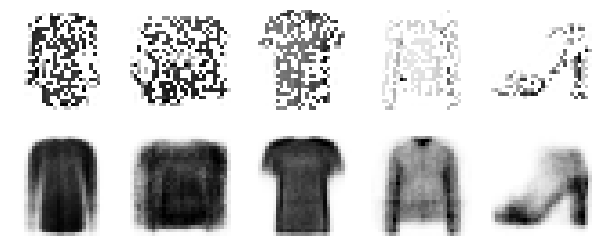

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4415 - rounded_accuracy: 0.7889 - val_loss: 0.3834 - val_rounded_accuracy: 0.8443
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3700 - rounded_accuracy: 0.8591 - val_loss: 0.3614 - val_rounded_accuracy: 0.8740
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3486 - rounded_accuracy: 0.8806 - val_loss: 0.3445 - val_rounded_accuracy: 0.8812
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3353 - rounded_accuracy: 0.8917 - val_loss: 0.3307 - val_rounded_accuracy: 0.8967
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3256 - rounded_accuracy: 0.8989 - val_loss: 0.3248 - val_rounded_accuracy: 0.9012
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3213 - rounded_accuracy: 0.9019 - val_loss: 0.3207 - val_rounded_accuracy: 0.9047
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 51ms/step


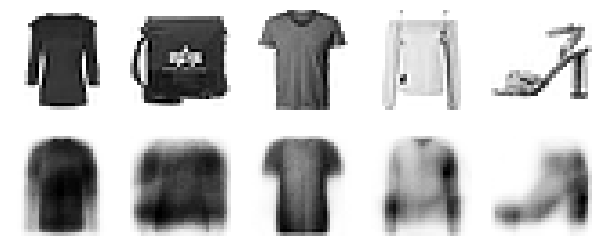

In [30]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [31]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [32]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

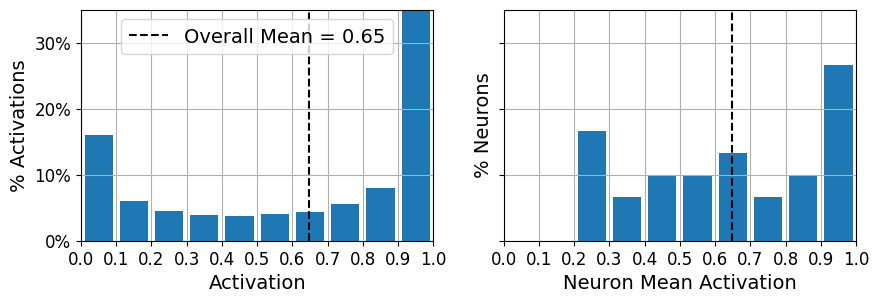

In [33]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4338 - rounded_accuracy: 0.8131 - val_loss: 0.3843 - val_rounded_accuracy: 0.8510
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3701 - rounded_accuracy: 0.8679 - val_loss: 0.3663 - val_rounded_accuracy: 0.8679
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3565 - rounded_accuracy: 0.8781 - val_loss: 0.3544 - val_rounded_accuracy: 0.8742
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3459 - rounded_accuracy: 0.8854 - val_loss: 0.3440 - val_rounded_accuracy: 0.8874
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3391 - rounded_accuracy: 0.8901 - val_loss: 0.3388 - val_rounded_accuracy: 0.8928
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3334 - rounded_accuracy: 0.8952 - val_loss: 0.3323 - val_rounded_accuracy: 0.8983
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 68ms/step


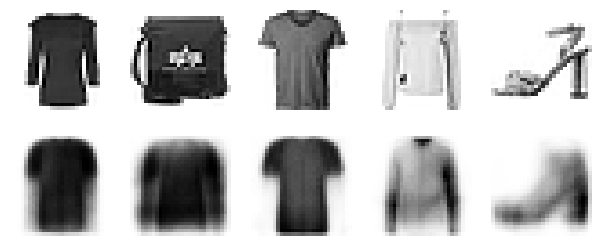

In [35]:
show_reconstructions(sparse_l1_ae)

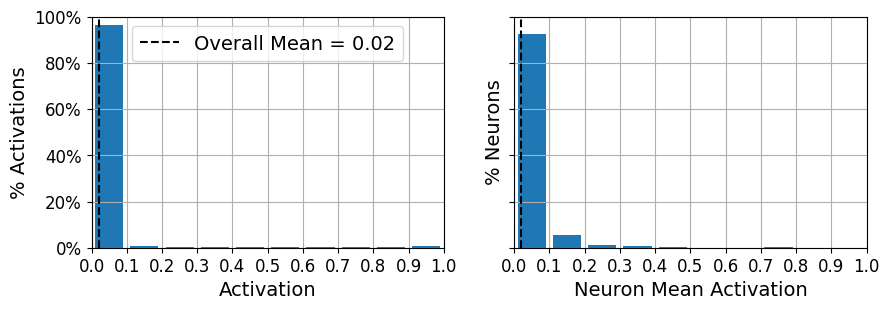

In [36]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


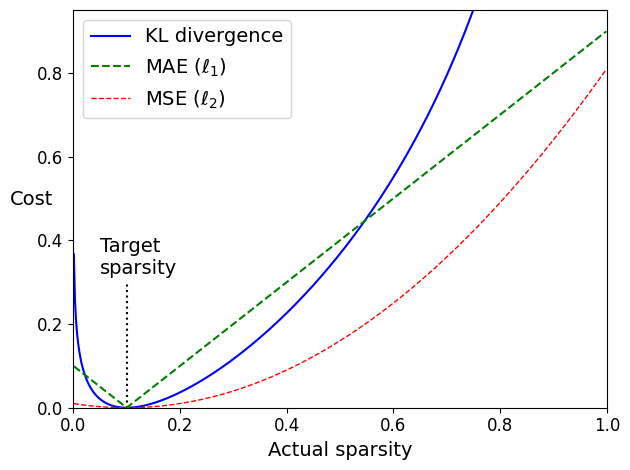

In [37]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [38]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4136 - rounded_accuracy: 0.8122 - val_loss: 0.3703 - val_rounded_accuracy: 0.8579
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3518 - rounded_accuracy: 0.8773 - val_loss: 0.3416 - val_rounded_accuracy: 0.8875
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3327 - rounded_accuracy: 0.8927 - val_loss: 0.3291 - val_rounded_accuracy: 0.8976
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3221 - rounded_accuracy: 0.9022 - val_loss: 0.3210 - val_rounded_accuracy: 0.9046
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3167 - rounded_accuracy: 0.9066 - val_loss: 0.3170 - val_rounded_accuracy: 0.9076
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3134 - rounded_accuracy: 0.9096 - val_loss: 0.3139 - val_rounded_accuracy: 0.9102
Epoch 7/10
1719/1719 [==================

Marie t'es trop fraiche
1/1 [==============================] - 0s 14ms/step


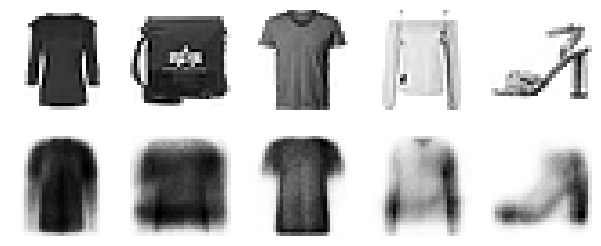

In [44]:
print("Marie t'es trop fraiche")



show_reconstructions(sparse_kl_ae)



Saving figure sparse_autoencoder_plot


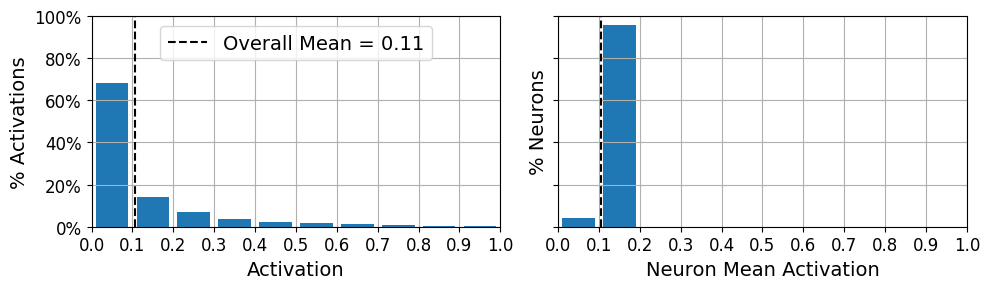

In [41]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [45]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4134 - rounded_accuracy: 0.8380 - val_loss: 0.3683 - val_rounded_accuracy: 0.8751
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3556 - rounded_accuracy: 0.8888 - val_loss: 0.3516 - val_rounded_accuracy: 0.8944
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3437 - rounded_accuracy: 0.8973 - val_loss: 0.3430 - val_rounded_accuracy: 0.8986
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3371 - rounded_accuracy: 0.9024 - val_loss: 0.3359 - val_rounded_accuracy: 0.9056
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3330 - rounded_accuracy: 0.9052 - val_loss: 0.3347 - val_rounded_accuracy: 0.9065
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3301 - rounded_accuracy: 0.9071 - val_loss: 0.3315 - val_rounded_accuracy: 0.9089
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 98ms/step


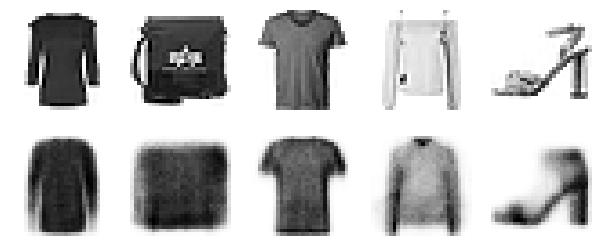

In [47]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [48]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


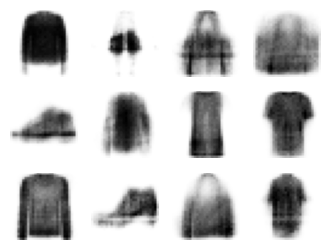

In [49]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# Generative Adversarial Networks

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [51]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [52]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [53]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


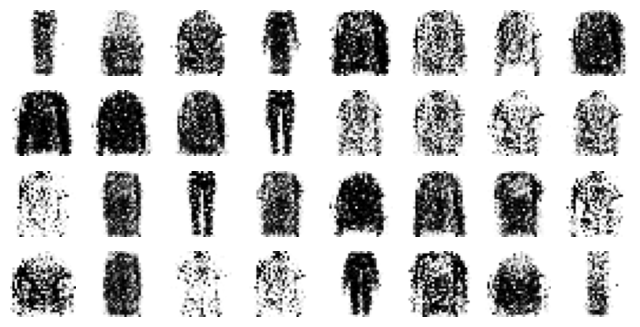

In [54]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


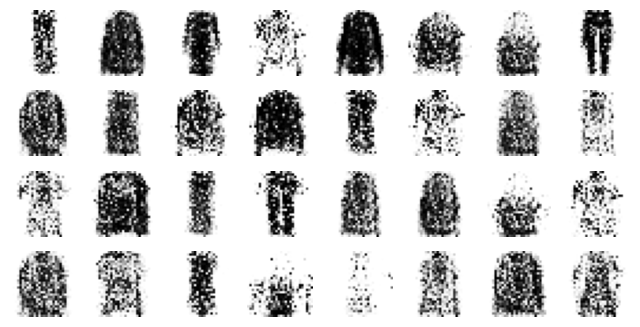

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [56]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [58]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [60]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [61]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False) 

# Extra Material

## Hashing Using a Binary Autoencoder

Let's load the Fashion MNIST dataset again:

In [63]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to learn to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [64]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4074 - rounded_accuracy: 0.8141 - val_loss: 0.3929 - val_rounded_accuracy: 0.8200
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3680 - rounded_accuracy: 0.8494 - val_loss: 0.3662 - val_rounded_accuracy: 0.8445
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3565 - rounded_accuracy: 0.8596 - val_loss: 0.3592 - val_rounded_accuracy: 0.8534
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3517 - rounded_accuracy: 0.8645 - val_loss: 0.3565 - val_rounded_accuracy: 0.8613
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3477 - rounded_accuracy: 0.8689 - val_loss: 0.3448 - val_rounded_accuracy: 0.8742
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3450 - rounded_accuracy: 0.8712 - val_loss: 0.3448 - val_rounded_accuracy: 0.8727
Epoch 7/10
1719/1719 [==================

The autoencoder compresses the information so much (down to 16 bits!) that it's quite lossy, but that's okay, we're using it to produce semantic hashes, not to perfectly reconstruct the images:

1/1 [==============================] - 0s 55ms/step


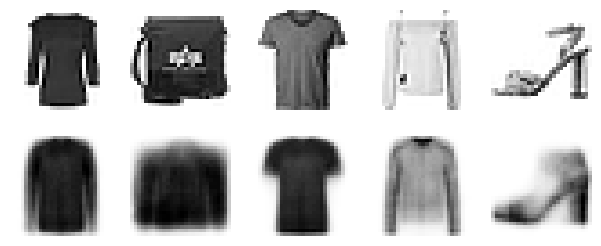

In [65]:
show_reconstructions(hashing_ae)
plt.show()

Notice that the outputs are indeed very close to 0 or 1 (left graph):

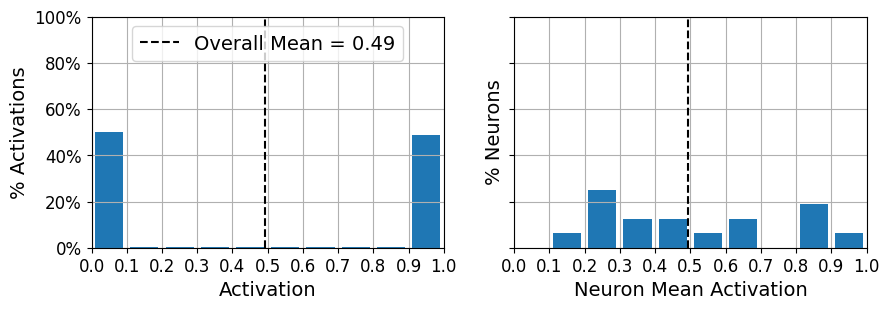

In [66]:
plot_activations_histogram(hashing_encoder)
plt.show()

Now let's see what the hashes look like for the first few images in the validation set:

In [67]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

157/157 [==============================] - 0s 651us/step
1100110011100001
1100110010000000
1101110010100001
1010110001100100
1000101100000000
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

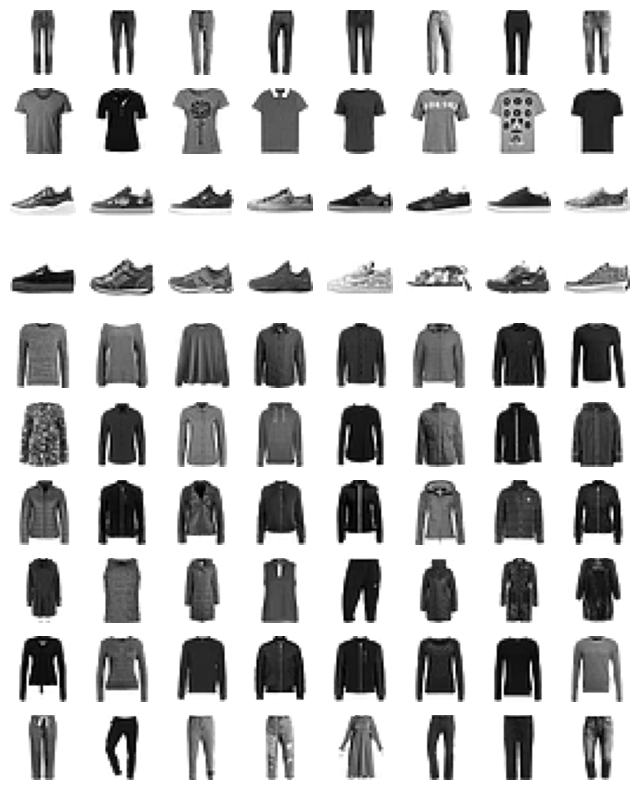

In [68]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")